In [3]:
import csv
import yaml
import sys
import os

import numpy as np
import pandas as pd
import math 

from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from matplotlib.patches import Patch

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
print(sns.__version__)

sys.path.append(os.path.abspath("../src"))
from utils import (
    label_to_id,
    get_threshold_dataset_indices
)

from eval import (
    align_labels_via_linear_sum_assignemt,
    compute_eval_metrics
)

0.13.2


In [2]:
!conda activate prpro-2024

In [3]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: c:\Users\ah140\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
!which python

/c/Users/ah140/anaconda3_/envs/hpc_test/python


In [5]:
taxonomy_path = "../data/metahit/taxonomy.tsv"
contig_processed_path = "../data/species_labelled_contigs.csv"
threshold_dataset_indices_path = "../data/threshold_dataset_indices.npy"
model_configs = "../config/models.yml"
results_path = "../results/heatmap"

# Read Model Configs
with open(model_configs, "r") as model_file:
    models_config = yaml.safe_load(model_file)

# Read Processed DNA Sequences
with open(contig_processed_path) as csvfile:
    data = list(csv.reader(csvfile, delimiter=","))
dna_sequences = [i[1] for i in data[1:]]
label_ids, id2label = label_to_id(data)

# Read Taxonomy
taxon = pd.read_csv(taxonomy_path, delimiter='\t', header=None)
species2genus = dict(zip(taxon[0], taxon[2]))
species2rank = dict(zip(taxon[0], taxon[3]))
id2genus = {i: label for i, label in enumerate(taxon[2])}
genus2id = {label: i for i, label in enumerate(taxon[2])}

threshold_dataset_indices = get_threshold_dataset_indices(label_ids, threshold_dataset_indices_path)
labels_evaluate = label_ids[threshold_dataset_indices == 0]
label_ids_rank = np.array([species2rank[id2label[l]] for l in labels_evaluate])
labels_evaluate = labels_evaluate[label_ids_rank=='genus']

# Assign a genus label to each strain
unique_id = np.unique(labels_evaluate)

label_ids_genus = np.array([genus2id[species2genus[id2label[l]]] for l in unique_id])

Loading threshold dataset indices
Threshold dataset comprise 18666 contigs (10.5%)



In [6]:
# Custom functions made for this plot
def assign_num_labels(labels, unique_labels):
    label2id_dict = {}
    id2label_dict = {}
    for idx, label in enumerate(unique_labels):
        label2id_dict[label] = idx
        id2label_dict[idx] = label
    new_labels = np.array([label2id_dict[l] for l in labels])
    return new_labels, id2label_dict

def round_up_two_decimals(value):
    scaled_value = value * 10 
    ceiling_value = math.ceil(scaled_value)  
    rounded_value = ceiling_value / 10 
    return rounded_value


def format_value(value):
    if value == int(value):
        return f"{int(value)}"
    else:
        return f"{value:.1f}"

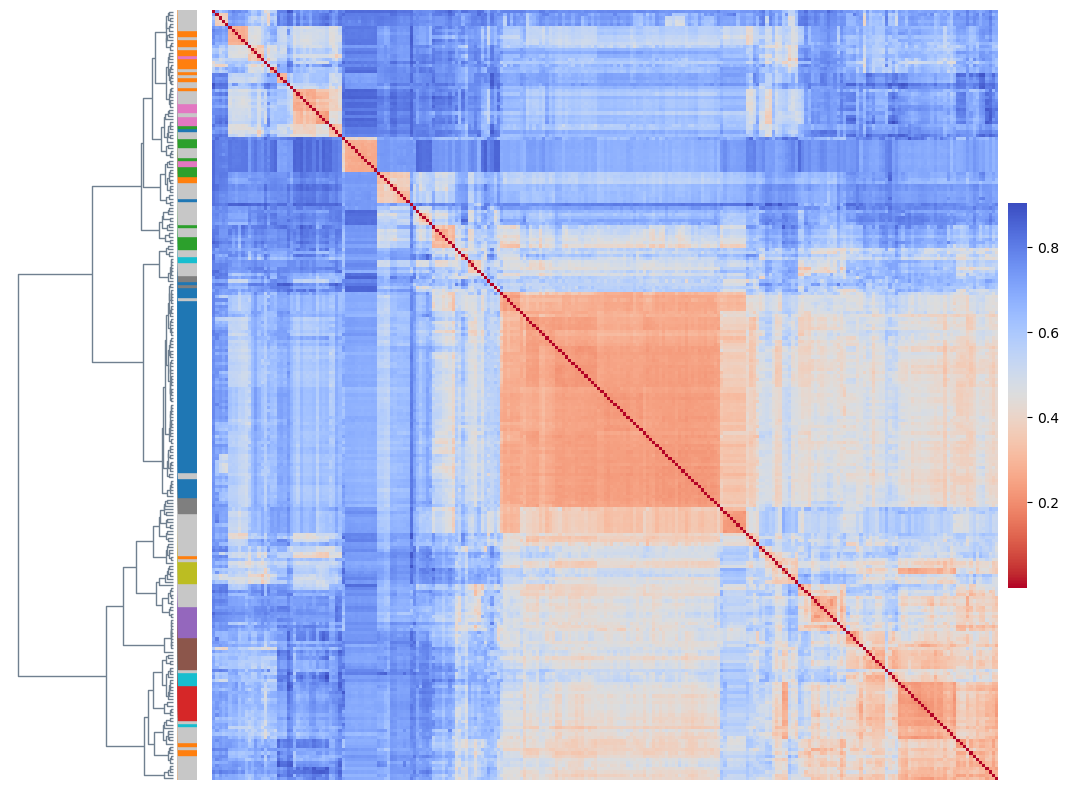

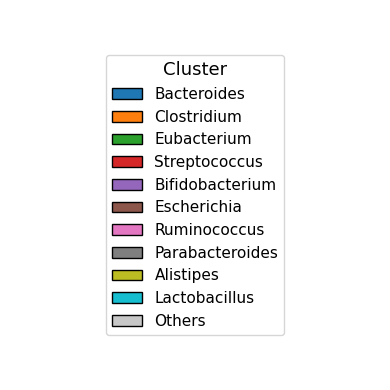

C:\Users\ah140\AppData\Local\Temp\ipykernel_14956\1639895799.py:29: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(distance_matrix, method='ward')
C:\Users\ah140\AppData\Local\Temp\ipykernel_14956\1639895799.py:29: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(distance_matrix, method='ward')
C:\Users\ah140\AppData\Local\Temp\ipykernel_14956\1639895799.py:29: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(distance_matrix, method='ward')


In [8]:
# Preprocessing for visualizing top 9 frequent genus
label_ids_mask = label_ids_genus.copy()
unique_genus, count = np.unique(label_ids_genus, return_counts=True)

# Assign the same label (999) for infrequent genus
mask = unique_genus[count <= 6]
label_ids_mask[np.isin(label_ids_genus, mask)] = 999

# Create a color dictionary
unique_mask, counts = np.unique(label_ids_mask, return_counts=True)
unique_labels = unique_mask[unique_mask != 999]
counts = counts[unique_mask != 999]
unique_labels = unique_labels[np.argsort(-counts)]
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
color_dict = {label: color for label, color in zip(unique_labels, colors)}
unique_mask = np.append(unique_labels, 999)
color_dict[999] = np.array([0.78039216, 0.78039216, 0.78039216, 1.        ])
id2genus[999] = 'Others'
genus2id['Others'] = 999

for model_name in models_config.keys():
    model_results_path = os.path.join(results_path, f"{model_name}_dist_mtx.npy")
    model_cluster_results_path = os.path.join(results_path, f"{model_name}_clusters")
    
    # Load a distance matrix for each model
    distance_matrix = np.load(model_results_path)

    # Create the hierarchical linkage matrix using Ward's method
    linkage = sch.linkage(distance_matrix, method='ward')

    # Create cluster labels using fcluster with a maximum of 64 clusters
    cluster_labels = fcluster(linkage, t=len(np.unique(label_ids_genus)), criterion='maxclust')
    np.save(model_cluster_results_path, cluster_labels)

    # Create a figure with two subplots: dendrogram and heatmap
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 5]})
    plt.subplots_adjust(left=0.8)

    plt.rcParams['lines.linewidth'] = 1
    # Plot the dendrogram on the left without labels and disable automatic color assignment
    dendrogram = sch.dendrogram(
        linkage,
        orientation='left',
        ax=ax[0],
        no_labels=True,
        color_threshold=0,
        above_threshold_color='slategrey'
    )
    ax[0].axis('off') 

    # Retrieve the order of leaves in the dendrogram
    leaf_order = dendrogram['leaves']
    N = len(leaf_order)

    # Get the y-axis limits to determine the positioning of the dots
    y_min, y_max = ax[0].get_ylim()

    # Evenly distribute y-positions for each leaf
    y_positions = np.linspace(y_min, y_max, N)

    # Retrieve the corresponding colors for each leaf based on the color dictionary
    leaf_colors = [color_dict.get(label_ids_mask[leaf], 'black') for leaf in leaf_order]

    # Determine the x-position for the dots, slightly to the right of the dendrogram
    x_min, x_max = ax[0].get_xlim()
    dot_x = x_max + (x_max - x_min) * 0.15

    # Adjust the x-axis limits to accommodate the dots
    ax[0].set_xlim(x_min, dot_x)

    # Plot colored dots to the right of the dendrogram
    scatter = ax[0].scatter(
        [dot_x] * N,     
        y_positions,      
        c=leaf_colors,    
        s=800,            
        marker='s',
        zorder=5         
    )

    # Sort the distance matrix according to the clustering result
    sorted_idx = sch.leaves_list(linkage)
    sorted_matrix = distance_matrix[sorted_idx][:, sorted_idx]

    sns.heatmap(
        sorted_matrix,
        ax=ax[1],
        cmap='coolwarm_r',
        cbar=True,
        xticklabels=False,
        yticklabels=False,
        cbar_kws={
            "shrink": 0.5,  # Adjust the height of the color bar
            "aspect": 20,   # Adjust the width of the color bar (smaller value = narrower)
            "pad": 0.01     # Move the color bar closer to the heatmap
        }
    )

    # Adjust the layout for better spacing#
    plt.tight_layout()

    if model_name == "DNABERT_S":
        #plt.show()
        plt.savefig(f"../figures/{model_name}_heatmap.png", bbox_inches='tight', dpi=300)

    # Create a separate figure for the legend
    legend_fig, legend_ax = plt.subplots(figsize=(4, 4))
    legend_ax.axis('off')  # Turn off axis for the legend figure

    # Create legend elements (colored patches)
    unique_colors = list(color_dict.values())
    legend_elements = [
        Patch(facecolor=color, edgecolor='black', label=id2genus[label]) 
        for label, color in zip(unique_mask, unique_colors)
    ]

    # Add the legend to the new figure
    legend_ax.legend(
        handles=legend_elements,
        title="Cluster",
        title_fontsize=13,  # Title font size
        loc='center',  # Position legend at the center
        borderaxespad=0.5,  # Adjust the border padding
        fontsize=11,  # Text font size
        frameon=True,  # Optional: Add a frame around the legend
    )

    legend_fig.tight_layout()
    if model_name == "DNABERT_S":
        plt.show()
        #legend_fig.savefig(f"../figures/{model_name}_legend.svg", bbox_inches='tight')


    # Close both figures to free memory
    plt.close(fig)
    plt.close(legend_fig)


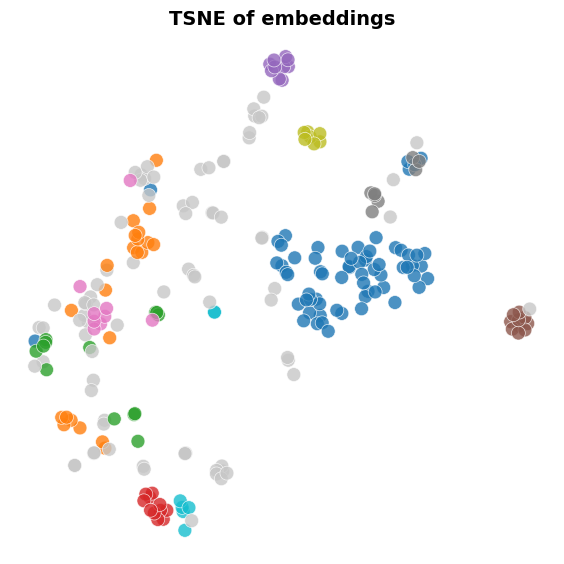

In [11]:
# Map a color to its corresponding label
label_colors = [color_dict[l] for l in label_ids_mask]

for model_name in models_config.keys():  
    # Load a distance matrix for each model
    model_results_path = os.path.join(results_path, f"{model_name}_dist_mtx.npy")
    distance_matrix = np.load(model_results_path)
    
    # Initialize t-SNE with 2 components and precomputed metric
    tsne = TSNE(n_components=2, metric='precomputed', random_state=42, init='random', perplexity=17)

    # Compute the t-SNE embedding
    tsne_results = tsne.fit_transform(distance_matrix)

    # Create a 2D plot
    fig, ax = plt.subplots(figsize=(6, 6))  # Adjusted figure size for better appearance

    # Scatter plot the t-SNE results
    scatter = ax.scatter(
        tsne_results[:, 0], 
        tsne_results[:, 1], 
        c=label_colors,             
        s=100,  # Adjusted marker size
        alpha=0.8,  # Set some transparency to avoid overplotting
        edgecolors='w',  # White edge color for better contrast
        linewidth=0.5  # Thin border for markers
    )


    # Create legend handles
    handles = [
        plt.Line2D(
            [0], [0], 
            marker='o', 
            color='w', 
            label=id2genus[label],
            markerfacecolor=color_dict[label], 
            markersize=10
        ) 
        for label in unique_mask
    ]
    
    # Remove x- and y-axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    
    ax.set_title(f'TSNE of embeddings', fontsize=14, fontweight='bold')

    # Adjust the layout to make room for the legend and title
    plt.tight_layout(pad=2.0)  

    # Optionally display the plot for a specific model
    if model_name == "DNABERT_S":
        #plt.savefig(f"../figures/{model_name}_tsne.svg", dpi=300, bbox_inches='tight', pad_inches=0.5)
        plt.show()
    
    # Close the figure to free memory
    plt.close(fig)

Bacteroides: 34
Clostridium: 55
Eubacterium: 50
Streptococcus: 10
Bifidobacterium: 17
Escherichia: 14
Ruminococcus: 53
Parabacteroides: 31
Alistipes: 21
Lactobacillus: 12
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  9 13 21 17  4  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  1  0  0  0  0  0  0]
 [ 4  0  0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
   0  0  0  0  0  0  3  5  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  1  1  0  0  0  0
   3  0  4  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7  4  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  6  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0

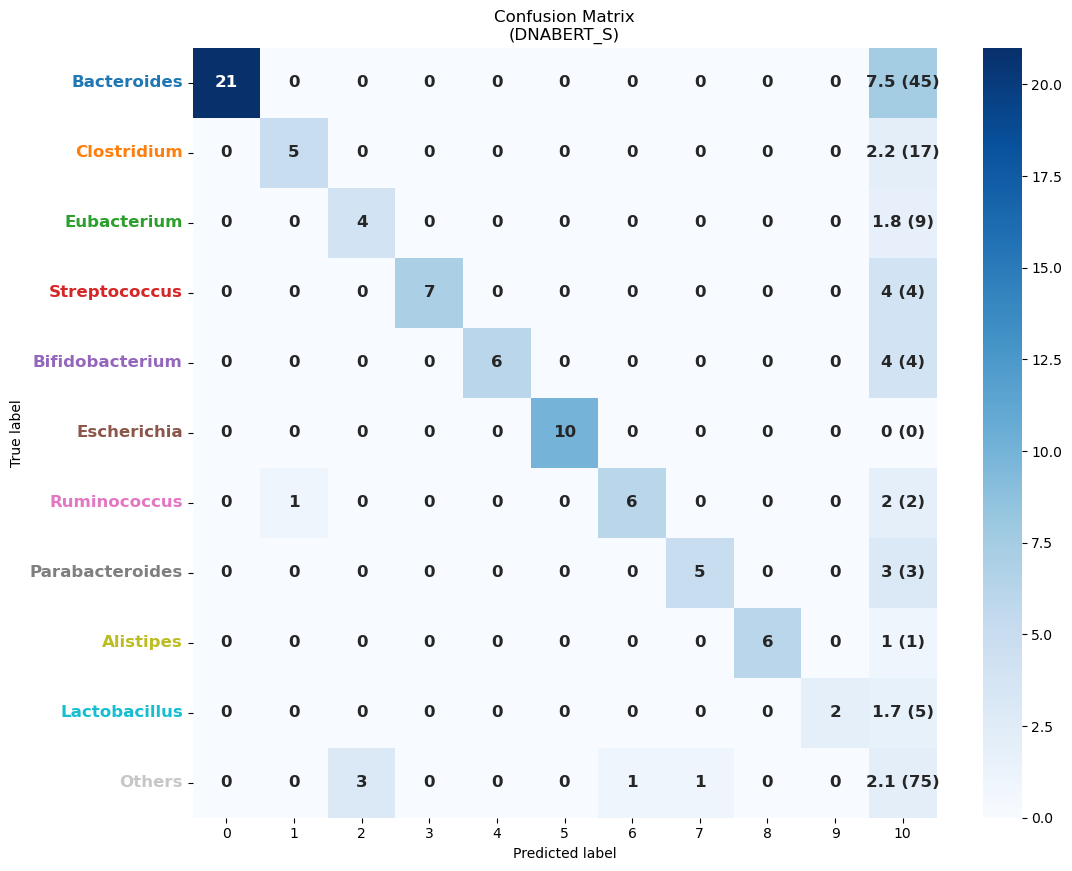

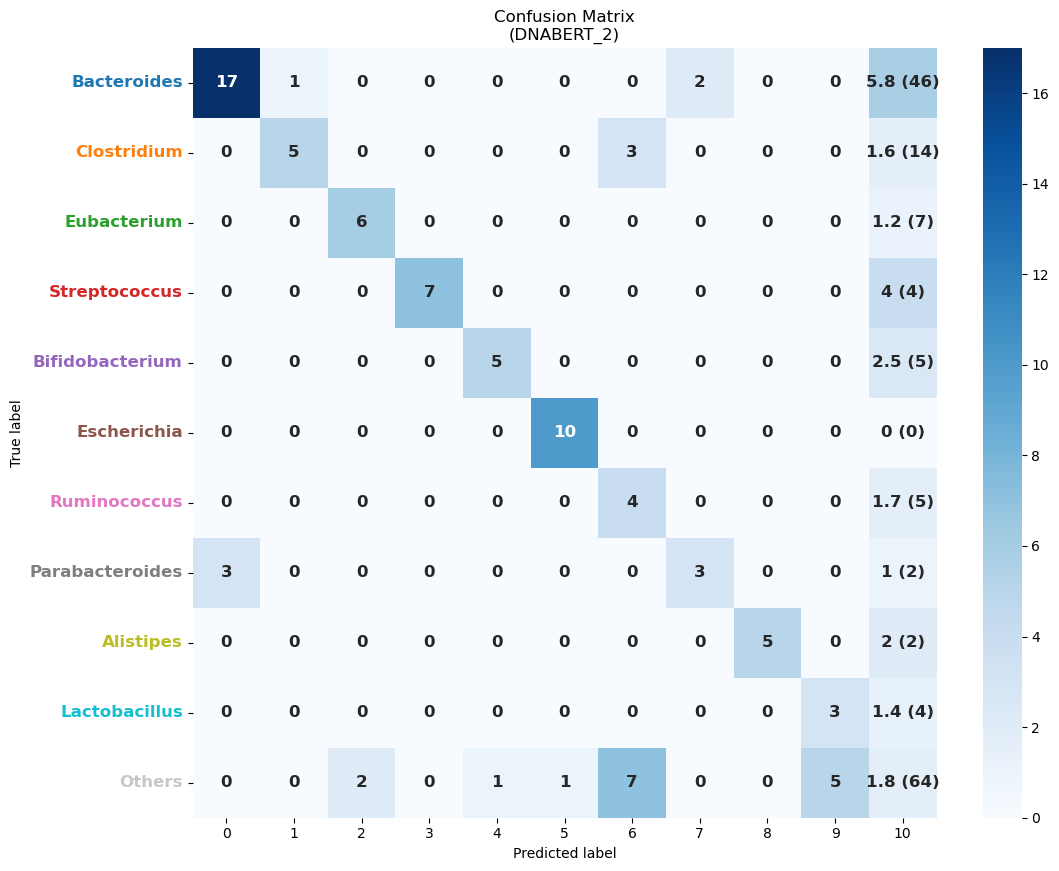

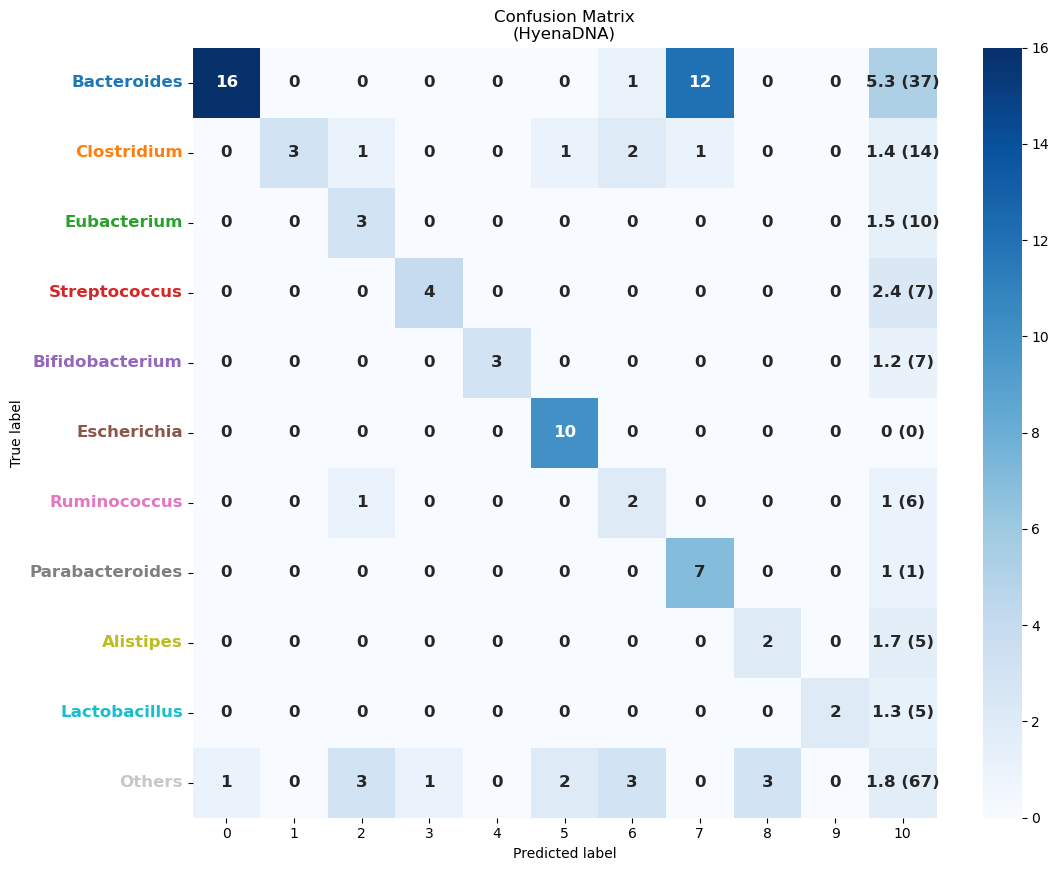

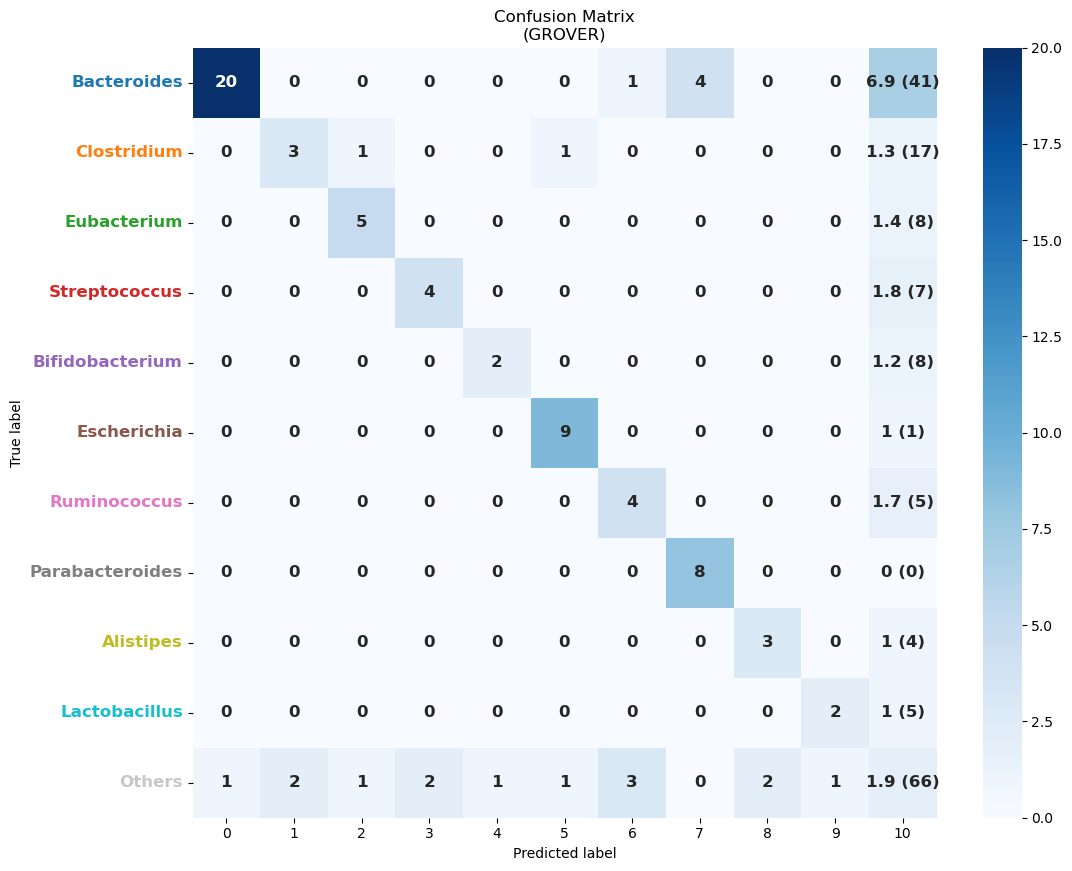

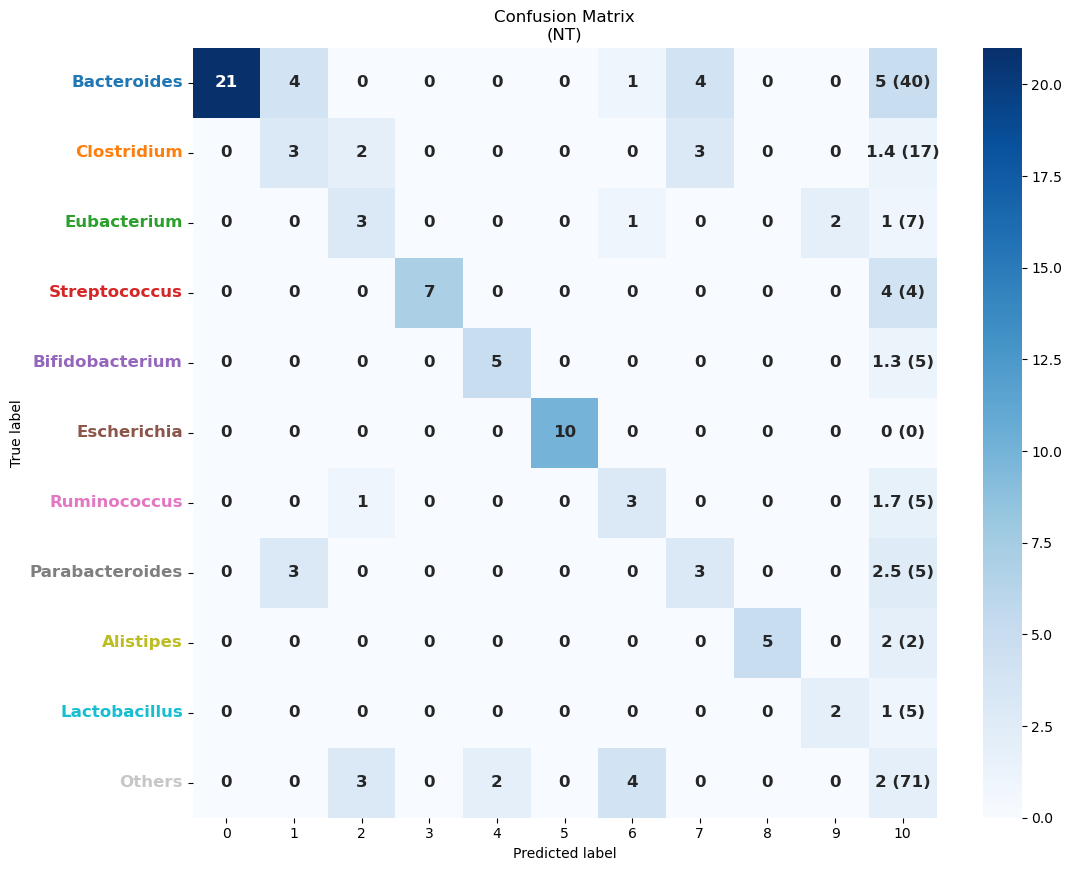

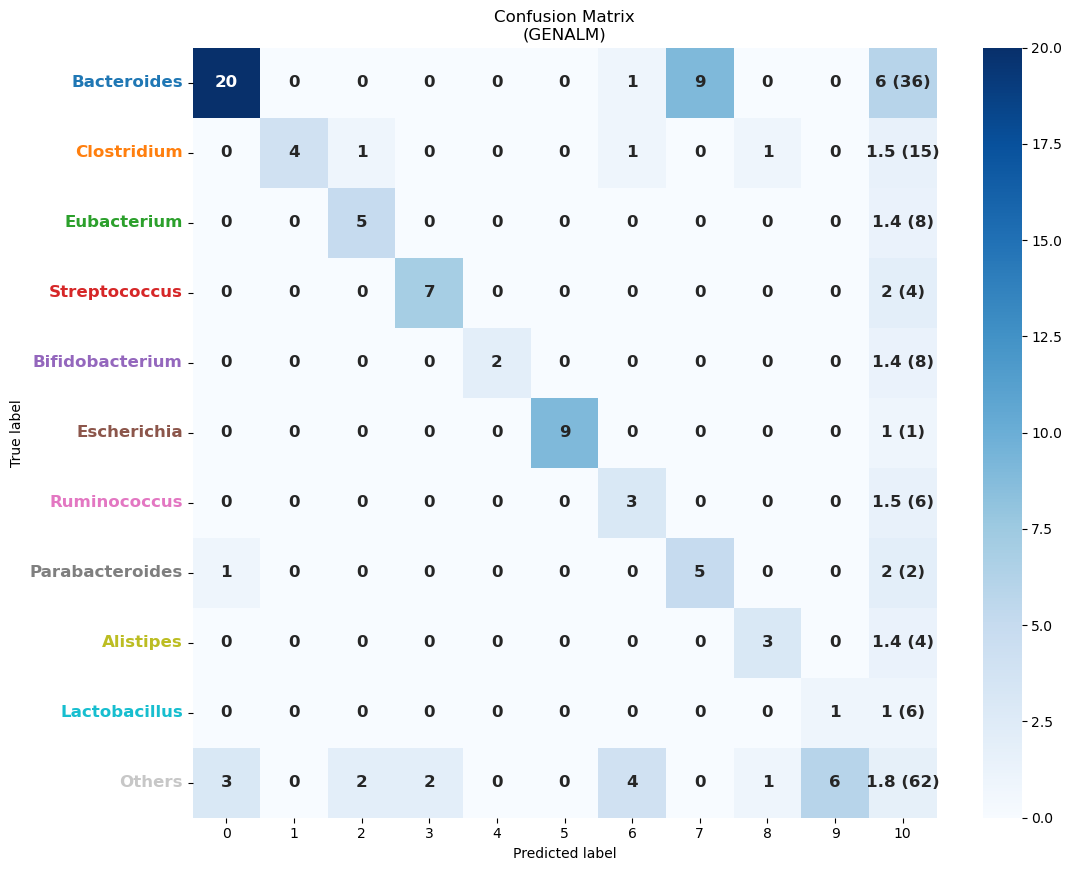

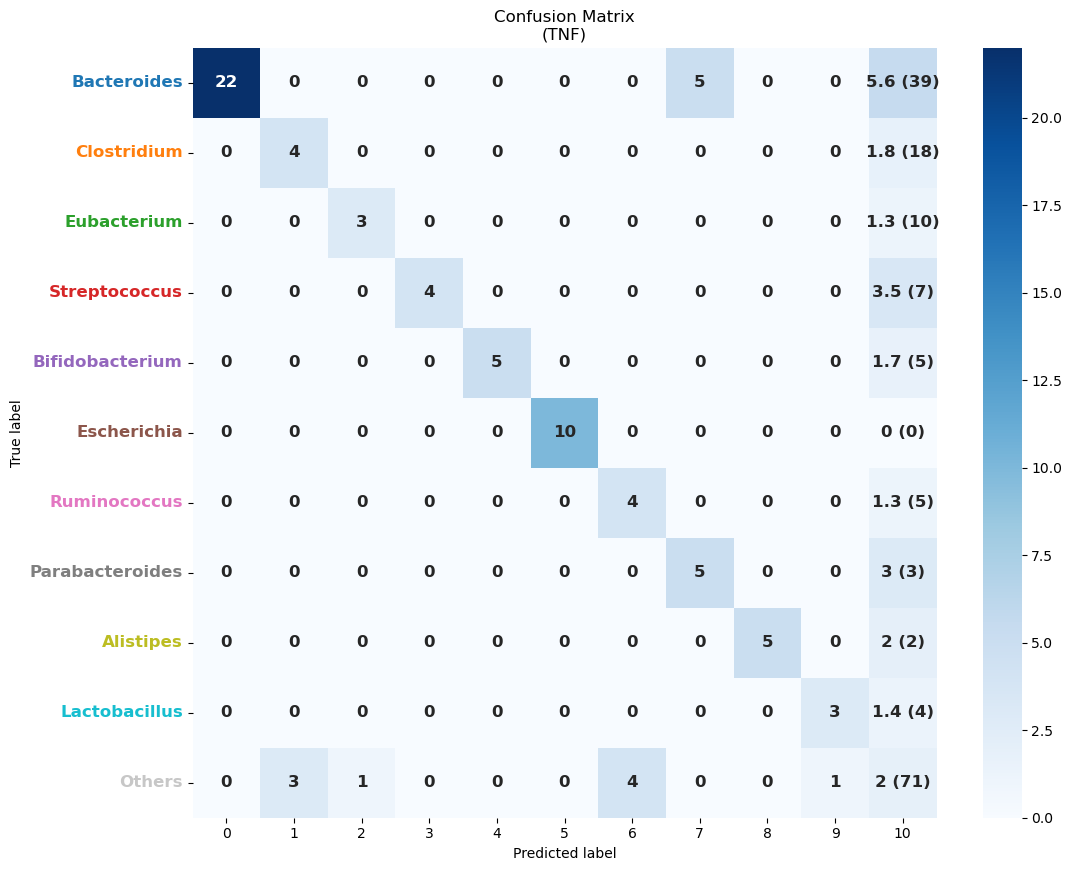

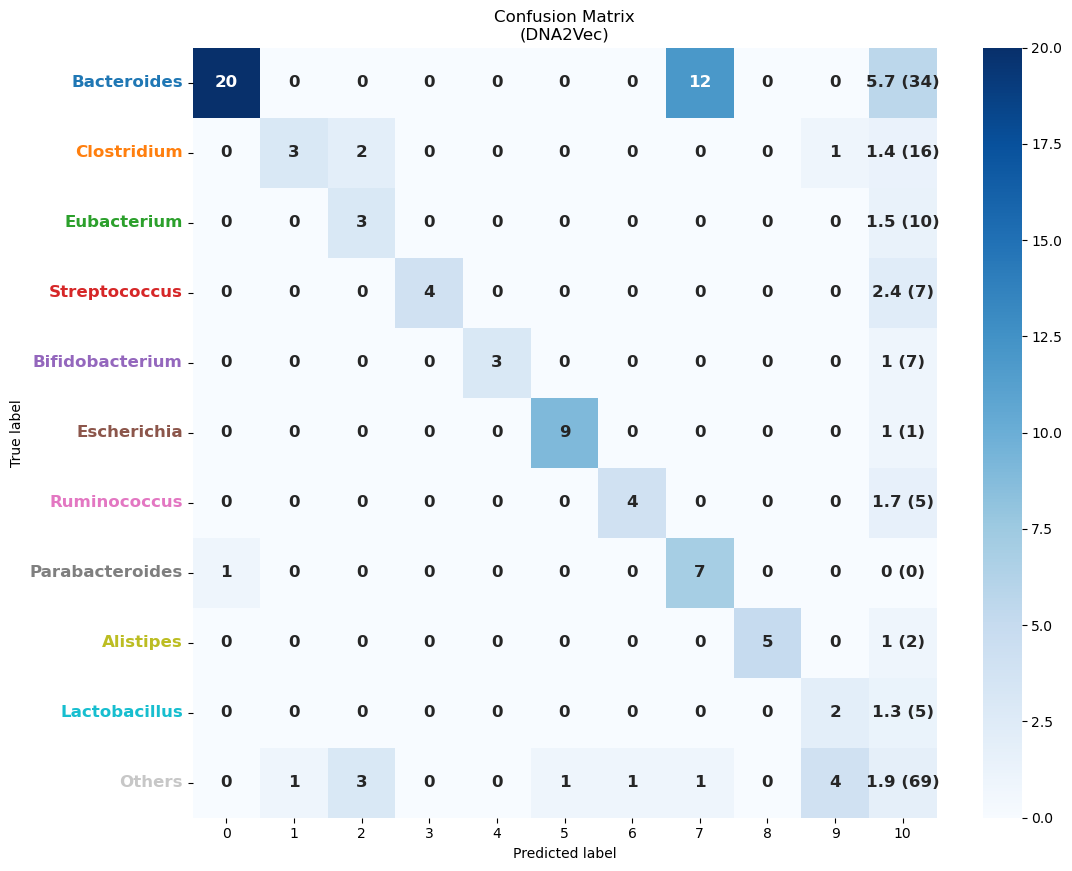

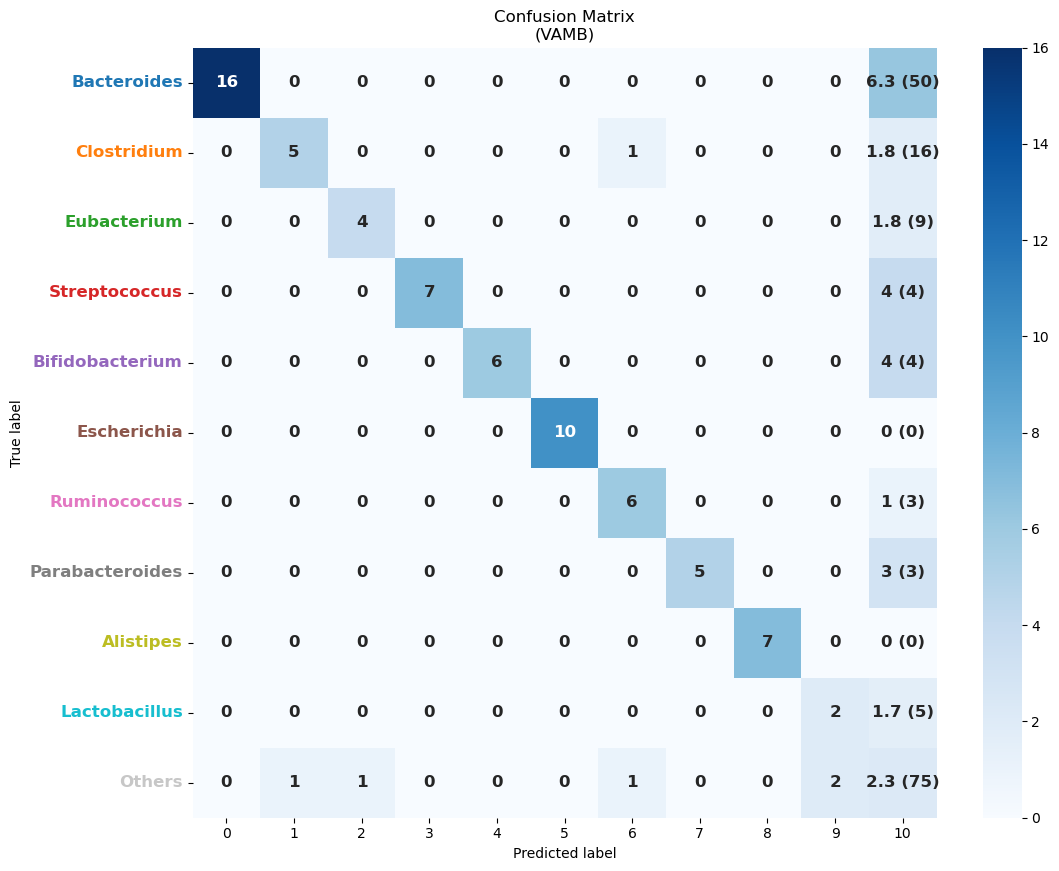

In [9]:
class_labels = [id2genus[l] for l in unique_mask]

for model_name in models_config.keys():  
    # Load a distance matrix for each model
    model_results_path = os.path.join(results_path, f"{model_name}_clusters.npy")
    cluster_labels = np.load(model_results_path)

    # Reassign labels to create a confusion matrix
    true_labels, true_dict = assign_num_labels(label_ids_mask, unique_mask)
    pred_labels, _ = assign_num_labels(cluster_labels, np.unique(cluster_labels))

    # Create a confusion matrix
    confusion_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(pred_labels))), dtype=int)

    for true_label, predicted_label in zip(true_labels, pred_labels):
        confusion_matrix[true_label, predicted_label] += 1

    # Identify the cluster number with most counts
    keep_indices = []

    for i in range(10):
        keep_indices.append(confusion_matrix[i].argmax())
        if model_name == "DNABERT_S":
            print(f"{id2genus[true_dict[i]]}: {confusion_matrix[i].argmax()}")

    all_indices = set(range(confusion_matrix.shape[1]))
    combine_indices = list(all_indices - set(keep_indices))

    # Calculate a non-zero average on axis=1
    non_zero_counts = np.count_nonzero(confusion_matrix[:, combine_indices], axis=1)
    sum_combined = confusion_matrix[:, combine_indices].sum(axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        combined_average = np.where(non_zero_counts != 0, sum_combined / non_zero_counts, 0)

    # Create a new 10x10 matrix
    combined_column_sum = confusion_matrix[:, combine_indices].sum(axis=1).reshape(-1, 1)
    combined_column_avg = combined_average.reshape(-1, 1)
    kept_columns = confusion_matrix[:, keep_indices]
    confusion_matrix_ = np.concatenate([kept_columns, combined_column_avg], axis=1)

    if model_name == "DNABERT_S":
        print(confusion_matrix)
        print(confusion_matrix_)
    
    plt.figure(figsize=(12, 10))

    annot_text = []
    for idx, row in enumerate(confusion_matrix_):
        row_text = [f"{int(cell)}" for cell in row[:-1]]
        
        avg_value = combined_column_avg[idx][0]
        sum_value = combined_column_sum[idx][0]  
        rounded_avg = round_up_two_decimals(avg_value)
        formatted_avg = format_value(rounded_avg)
        formatted_sum = f"{int(sum_value)}"
        
        
        rightmost_annotation = f"{formatted_avg} ({formatted_sum})"
        
        row_text.append(rightmost_annotation)
        annot_text.append(row_text)

    annot_text = np.array(annot_text)

    ax = sns.heatmap(confusion_matrix_, annot=annot_text, fmt='', cmap='Blues', vmin=confusion_matrix_.min(), vmax=confusion_matrix_.max(), cbar=True,
                xticklabels=[i for i in range(11)], yticklabels=class_labels, annot_kws={"size": 12, "weight": "bold"})

    for tick in ax.get_yticklabels():
        label = genus2id[tick.get_text()]
        if label in color_dict:
            tick.set_color(color_dict[label])
        tick.set_fontsize(12)            
        tick.set_fontweight('bold')   

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix\n({model_name})')

    # Save the plot to the specified path with additional padding
    #plt.savefig(f"figures/{model_name}_cm.svg", dpi=300, bbox_inches='tight', pad_inches=0.5)
    if model_name == "DNABERT_S":
        plt.show()
    plt.close(fig)

C:\Users\ah140\AppData\Local\Temp\ipykernel_14956\4031676341.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').reversed()


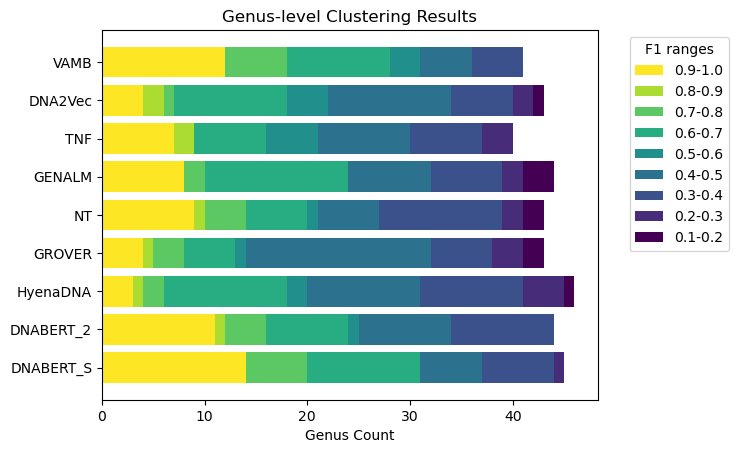

f1 count (<class 'type'>): 
0.1-0.2: [0, 0, 1, 2, 2, 3, 0, 1, 0], 
0.2-0.3: [1, 0, 4, 3, 2, 2, 3, 2, 0], 
0.3-0.4: [7, 10, 10, 6, 12, 7, 7, 6, 5], 
0.4-0.5: [6, 9, 11, 18, 6, 8, 9, 12, 5],
0.5-0.6: [0, 1, 2, 1, 1, 0, 5, 4, 3], 
0.6-0.7: [11, 8, 12, 5, 6, 14, 7, 11, 10],  
0.7-0.8: [6, 4, 2, 3, 4, 2, 0, 1, 6],
0.8-0.9: [0, 1, 1, 1, 1, 0, 2, 2, 0], 
0.9-1.0: [14, 11, 3, 4, 9, 8, 7, 4, 12]


In [11]:
# Create a colormap
cmap = cm.get_cmap('viridis').reversed()
colors = cmap(np.linspace(0, 1, 9)) 

f1_01 = []
f1_02 = []
f1_03 = []
f1_04 = []
f1_05 = []
f1_06 = []
f1_07 = []
f1_08 = []
f1_09 = []

for model_name in models_config.keys():  
    # Load a distance matrix for each model
    model_results_path = os.path.join(results_path, f"{model_name}_clusters.npy")
    cluster_labels = np.load(model_results_path)

    # Reassign labels to calculate f1 scores
    label_mappings = align_labels_via_linear_sum_assignemt(
                label_ids_genus, cluster_labels
            )

    predicted_labels = [label_mappings[label] for label in cluster_labels]

    # Calculate F1 scores for each class
    f1_bin = f1_score(
        label_ids_genus, predicted_labels, average=None, zero_division=0
    )
    f1_bin.sort()

    # Define thresholds for evaluation
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    f1_results = []

    # Evaluate F1 scores above each threshold
    for threshold in thresholds:
        f1_results.append(len(np.where(f1_bin > threshold)[0]))
    
    f1_01.append(f1_results[0]-f1_results[1])
    f1_02.append(f1_results[1]-f1_results[2])
    f1_03.append(f1_results[2]-f1_results[3])
    f1_04.append(f1_results[3]-f1_results[4])
    f1_05.append(f1_results[4]-f1_results[5])
    f1_06.append(f1_results[5]-f1_results[6])
    f1_07.append(f1_results[6]-f1_results[7])
    f1_08.append(f1_results[7]-f1_results[8])
    f1_09.append(f1_results[8])

x_positions = np.arange(len(models_config.keys()))

# plot a stacked bar graph
plt.barh(x_positions, f1_09, color=colors[0], label='0.9-1.0')
plt.barh(x_positions, f1_08, left=f1_09, color=colors[1], label='0.8-0.9')
plt.barh(x_positions, f1_07, left=np.add(f1_09, f1_08), color=colors[2], label='0.7-0.8')
plt.barh(x_positions, f1_06, left=np.add(np.add(f1_09, f1_08), f1_07), color=colors[3], label='0.6-0.7')
plt.barh(x_positions, f1_05, left=np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), color=colors[4], label='0.5-0.6')
plt.barh(x_positions, f1_04, left=np.add(np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), f1_05), color=colors[5], label='0.4-0.5')
plt.barh(x_positions, f1_03, left=np.add(np.add(np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), f1_05), f1_04), color=colors[6], label='0.3-0.4')
plt.barh(x_positions, f1_02, left=np.add(np.add(np.add(np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), f1_05), f1_04), f1_03), color=colors[7], label='0.2-0.3')
plt.barh(x_positions, f1_01, left=np.add(np.add(np.add(np.add(np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), f1_05), f1_04), f1_03), f1_02), color=colors[8], label='0.1-0.2')

# add the labels and titile
plt.yticks(x_positions, models_config.keys())
plt.xlabel('Genus Count')
plt.title(f'Genus-level Clustering Results')
plt.legend(title='F1 ranges', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the figure as an SVG file
#plt.savefig(f'figures/gc_f1.svg', bbox_inches='tight')

plt.show()
plt.close()

print(f'f1 count ({type}): \n0.1-0.2: {f1_01}, \n0.2-0.3: {f1_02}, \n0.3-0.4: {f1_03}, \n0.4-0.5: {f1_04},\n0.5-0.6: {f1_05}, \n0.6-0.7: {f1_06},  \n0.7-0.8: {f1_07},\n0.8-0.9: {f1_08}, \n0.9-1.0: {f1_09}')

### *Make the same plots only with most 10 frequent genomes

[[ 0  0  0  0  0  0  1  1  4 60]
 [ 5  2  0  0  0  1 11  3  0  0]
 [ 0  0  0  0  0  5  0  8  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  8  0  0]
 [ 0  0  0  0  0  0  0  0  3  5]
 [ 0  0  0  7  0  0  0  0  0  0]
 [ 0  5  0  0  0  2  0  0  0  0]]


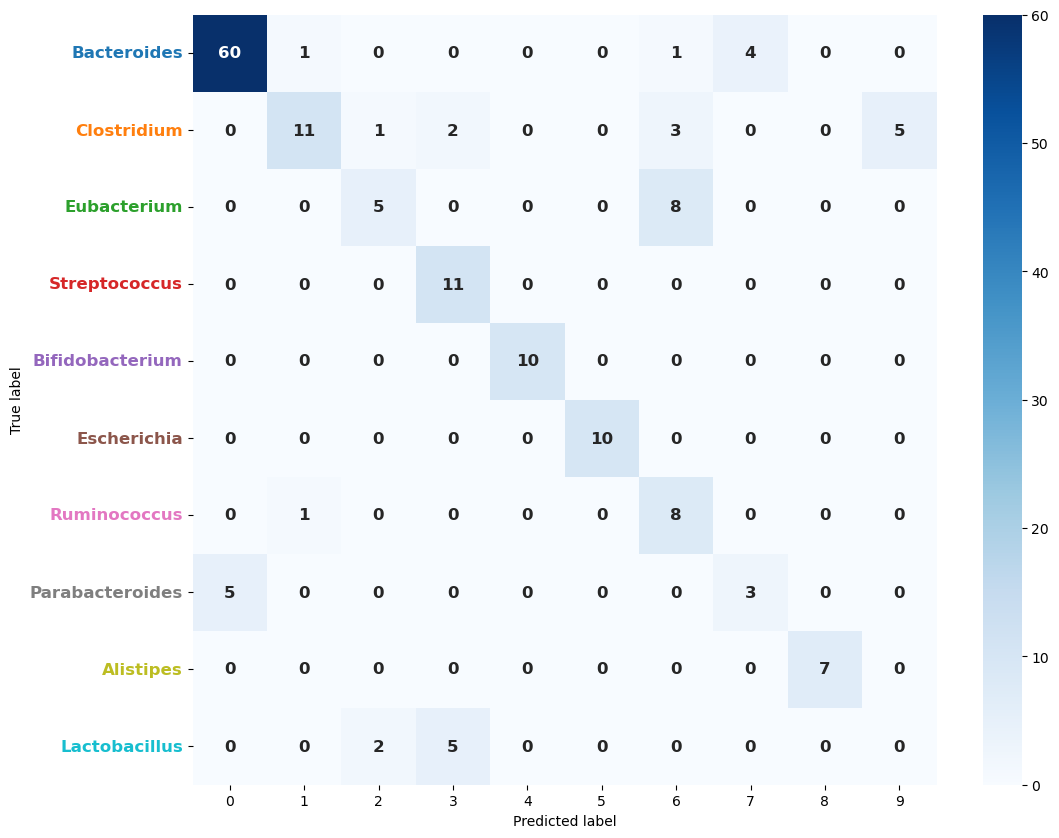

C:\Users\ah140\AppData\Local\Temp\ipykernel_14956\3005927308.py:31: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(dist_mtx, method='ward')
C:\Users\ah140\AppData\Local\Temp\ipykernel_14956\3005927308.py:31: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(dist_mtx, method='ward')
C:\Users\ah140\AppData\Local\Temp\ipykernel_14956\3005927308.py:31: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(dist_mtx, method='ward')


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

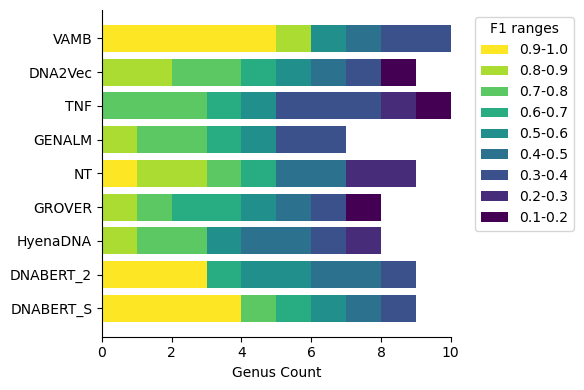

f1 count (<class 'type'>): 
0.1-0.2: [0, 0, 0, 1, 0, 0, 1, 1, 0], 
0.2-0.3: [0, 0, 1, 0, 2, 0, 1, 0, 0], 
0.3-0.4: [1, 1, 1, 1, 0, 2, 3, 1, 2], 
0.4-0.5: [1, 2, 2, 1, 2, 0, 0, 1, 1],
0.5-0.6: [1, 2, 1, 1, 0, 1, 1, 1, 1], 
0.6-0.7: [1, 1, 0, 2, 1, 1, 1, 1, 0],  
0.7-0.8: [1, 0, 2, 1, 1, 2, 3, 2, 0],
0.8-0.9: [0, 0, 1, 1, 2, 1, 0, 2, 1], 
0.9-1.0: [4, 3, 0, 0, 1, 0, 0, 0, 5]


In [13]:
# Calculate a new distance matrix with genomes of interest
labels_interest = [id for id in color_dict.keys() if id!=999]
indices = np.where(np.isin(label_ids_genus, labels_interest))[0]
colors = cmap(np.linspace(0, 1, 9)) 

f1_01 = []
f1_02 = []
f1_03 = []
f1_04 = []
f1_05 = []
f1_06 = []
f1_07 = []
f1_08 = []
f1_09 = []

for model_name in models_config.keys():   
    model_results_path = os.path.join(results_path, f"{model_name}_dist_mtx.npy")
    
    # Load a distance matrix for each model
    distance_matrix = np.load(model_results_path)

    dist_mtx = np.zeros((len(indices), len(indices)))

    for i, idx1 in enumerate(indices):
        for j, idx2 in enumerate(indices):
            if i <= j:
                dist_mtx[i][j] = distance_matrix[idx1][idx2]
                dist_mtx[j][i] = distance_matrix[idx2][idx1]

    # Create the hierarchical linkage matrix using Ward's method
    linkage = sch.linkage(dist_mtx, method='ward')

    # Create cluster labels using fcluster with a maximum of 10 clusters
    cluster_labels = fcluster(linkage, t=len(labels_interest), criterion='maxclust')

    # Create a figure with two subplots: dendrogram and heatmap
    fig, ax = plt.subplots(1, 2, figsize=(18, 12), gridspec_kw={'width_ratios': [1, 5]})
    plt.subplots_adjust(left=0.8)

    # Plot the dendrogram on the left without labels and disable automatic color assignment
    dendrogram = sch.dendrogram(
        linkage,
        orientation='left',
        ax=ax[0],
        no_labels=True,
        color_threshold=0 
    )
    ax[0].axis('off') 

    # Retrieve the order of leaves in the dendrogram
    leaf_order = dendrogram['leaves']
    N = len(leaf_order)

    # Get the y-axis limits to determine the positioning of the dots
    y_min, y_max = ax[0].get_ylim()

    # Evenly distribute y-positions for each leaf
    y_positions = np.linspace(y_min, y_max, N)

    # Retrieve the corresponding colors for each leaf based on the color dictionary
    leaf_colors = [color_dict.get(label_ids_genus[indices][leaf], 'black') for leaf in leaf_order]

    # Determine the x-position for the dots, slightly to the right of the dendrogram
    x_min, x_max = ax[0].get_xlim()
    dot_x = x_max + (x_max - x_min) * 0.05  

    # Adjust the x-axis limits to accommodate the dots
    ax[0].set_xlim(x_min, dot_x)

    # Plot colored dots to the right of the dendrogram
    scatter = ax[0].scatter(
        [dot_x] * N,     
        y_positions,      
        c=leaf_colors,    
        s=250,            
        marker='s',
        zorder=5         
    )

    # Create a color legend
    
    unique_colors = [color_dict[color] for color in color_dict.keys() if color != 999]
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=id2genus[label]) for label, color in zip(labels_interest, unique_colors)]

    # Add the legend to the dendrogram axis
    fig.legend(handles=legend_elements, title="Cluster", bbox_to_anchor=(-0.1, 0.95), loc='upper left', borderaxespad=0.)

    # Sort the distance matrix according to the clustering result
    sorted_idx = sch.leaves_list(linkage)
    sorted_matrix = distance_matrix[sorted_idx][:, sorted_idx]

    # Create a heatmap of the sorted distance matrix
    sns.heatmap(
        sorted_matrix,
        ax=ax[1],
        cmap='coolwarm',
        cbar=True,
        xticklabels=False,
        yticklabels=False
    )
    ax[1].set_title(f"Heatmap with Hierarchical Clustering\n({model_name})", fontsize=16)

    # Adjust the layout for better spacing
    plt.tight_layout()

    # Save the resulting plot to the specified file path
    #plt.savefig(f"figures/{model_name}_heatmap_10.svg", bbox_inches='tight')
    #if model_name == "DNABERT_S":
        #plt.show()
    plt.close()



    # Reassign labels to create a confusion matrix
    true_labels, true_dict = assign_num_labels(label_ids_genus[indices], labels_interest)
    pred_labels, _ = assign_num_labels(cluster_labels, np.unique(cluster_labels))

    # Create a confusion matrix
    confusion_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(pred_labels))), dtype=int)

    for true_label, predicted_label in zip(true_labels, pred_labels):
        confusion_matrix[true_label, predicted_label] += 1

    if model_name == "DNABERT_S":
        print(confusion_matrix)
    
    # Identify the cluster number with most counts
    clust_dict = align_labels_via_linear_sum_assignemt(
                pred_labels, true_labels
            )

    max_count_indices = [clust_dict[label] for label in true_dict.keys()]

    plt.figure(figsize=(12, 10))

    ax = sns.heatmap(confusion_matrix[:, max_count_indices], annot=True, fmt='d', cmap='Blues', vmin=confusion_matrix.min(), vmax=confusion_matrix.max(), cbar=True,
                xticklabels=[i for i in range(10)], yticklabels=[label for label in class_labels if label != "Others"], annot_kws={"size": 12, "weight": "bold"})

    # Color y-axis labels
    for tick in ax.get_yticklabels():
        id = genus2id[tick.get_text()]
        if id in color_dict:
            tick.set_color(color_dict[id])

        tick.set_fontsize(12)
        tick.set_fontweight('bold')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    #plt.title(f'Confusion Matrix\n({model_name})')

    # Save the plot to the specified path with additional padding
    #plt.savefig(f"figures/{model_name}_cm_10.svg", dpi=300, bbox_inches='tight', pad_inches=0.5)
    if model_name == "DNABERT_S":
        plt.show()
    plt.close()


    plt.figure(figsize=(6, 4))  # Adjusted figure size for better appearance
    # Reassign labels to calculate f1 scores
    label_mappings = align_labels_via_linear_sum_assignemt(
                label_ids_genus[indices], cluster_labels
            )

    predicted_labels = [label_mappings[label] for label in cluster_labels]

    # Calculate F1 scores for each class
    f1_bin = f1_score(
        label_ids_genus[indices], predicted_labels, average=None, zero_division=0
    )
    f1_bin.sort()

    # Define thresholds for evaluation
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    f1_results = []

    # Evaluate F1 scores above each threshold
    for threshold in thresholds:
        f1_results.append(len(np.where(f1_bin > threshold)[0]))
    
    f1_01.append(f1_results[0]-f1_results[1])
    f1_02.append(f1_results[1]-f1_results[2])
    f1_03.append(f1_results[2]-f1_results[3])
    f1_04.append(f1_results[3]-f1_results[4])
    f1_05.append(f1_results[4]-f1_results[5])
    f1_06.append(f1_results[5]-f1_results[6])
    f1_07.append(f1_results[6]-f1_results[7])
    f1_08.append(f1_results[7]-f1_results[8])
    f1_09.append(f1_results[8])

x_positions = np.arange(len(models_config.keys()))

# plot a stacked bar graph
plt.barh(x_positions, f1_09, color=colors[0], label='0.9-1.0')
plt.barh(x_positions, f1_08, left=f1_09, color=colors[1], label='0.8-0.9')
plt.barh(x_positions, f1_07, left=np.add(f1_09, f1_08), color=colors[2], label='0.7-0.8')
plt.barh(x_positions, f1_06, left=np.add(np.add(f1_09, f1_08), f1_07), color=colors[3], label='0.6-0.7')
plt.barh(x_positions, f1_05, left=np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), color=colors[4], label='0.5-0.6')
plt.barh(x_positions, f1_04, left=np.add(np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), f1_05), color=colors[5], label='0.4-0.5')
plt.barh(x_positions, f1_03, left=np.add(np.add(np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), f1_05), f1_04), color=colors[6], label='0.3-0.4')
plt.barh(x_positions, f1_02, left=np.add(np.add(np.add(np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), f1_05), f1_04), f1_03), color=colors[7], label='0.2-0.3')
plt.barh(x_positions, f1_01, left=np.add(np.add(np.add(np.add(np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), f1_05), f1_04), f1_03), f1_02), color=colors[8], label='0.1-0.2')

ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# add the labels and titile
plt.yticks(x_positions, models_config.keys())
plt.xlabel('Genus Count')
#plt.title(f'Genus-level Clustering Results')
plt.legend(title='F1 ranges', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the figure as an SVG file
plt.tight_layout()
#plt.savefig(f'../figures/gc_f1_10.svg', bbox_inches='tight')
plt.show()
plt.close()

print(f'f1 count ({type}): \n0.1-0.2: {f1_01}, \n0.2-0.3: {f1_02}, \n0.3-0.4: {f1_03}, \n0.4-0.5: {f1_04},\n0.5-0.6: {f1_05}, \n0.6-0.7: {f1_06},  \n0.7-0.8: {f1_07},\n0.8-0.9: {f1_08}, \n0.9-1.0: {f1_09}')

[[ 0  0  0  0  0  0  1  1  4 60]
 [ 5  2  0  0  0  1 11  3  0  0]
 [ 0  0  0  0  0  5  0  8  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  8  0  0]
 [ 0  0  0  0  0  0  0  0  3  5]
 [ 0  0  0  7  0  0  0  0  0  0]
 [ 0  5  0  0  0  2  0  0  0  0]]


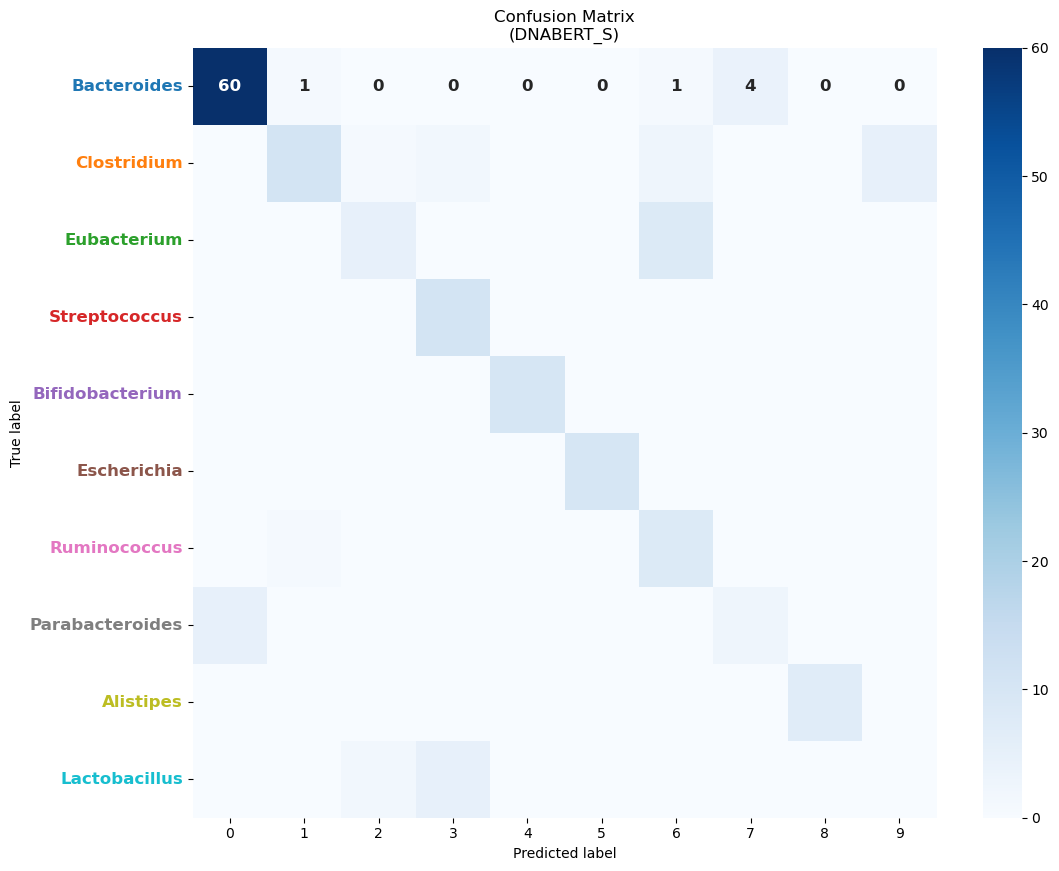

C:\Users\ah140\AppData\Local\Temp\ipykernel_6792\4016805835.py:30: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(dist_mtx, method='ward')
C:\Users\ah140\AppData\Local\Temp\ipykernel_6792\4016805835.py:30: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(dist_mtx, method='ward')
C:\Users\ah140\AppData\Local\Temp\ipykernel_6792\4016805835.py:30: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(dist_mtx, method='ward')


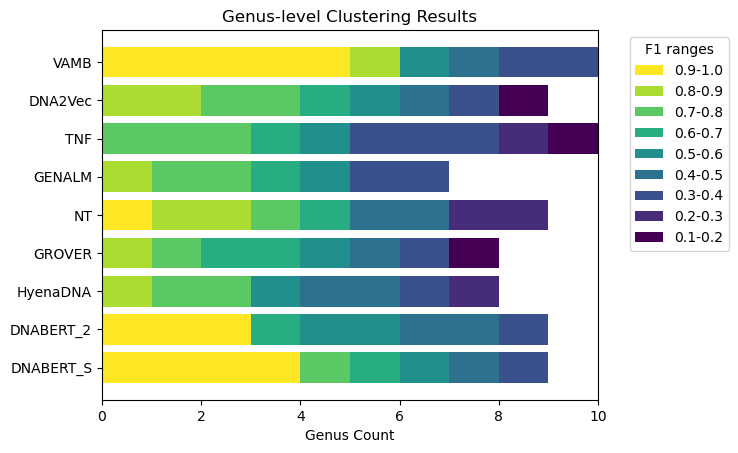

f1 count (<class 'type'>): 
0.1-0.2: [0, 0, 0, 1, 0, 0, 1, 1, 0], 
0.2-0.3: [0, 0, 1, 0, 2, 0, 1, 0, 0], 
0.3-0.4: [1, 1, 1, 1, 0, 2, 3, 1, 2], 
0.4-0.5: [1, 2, 2, 1, 2, 0, 0, 1, 1],
0.5-0.6: [1, 2, 1, 1, 0, 1, 1, 1, 1], 
0.6-0.7: [1, 1, 0, 2, 1, 1, 1, 1, 0],  
0.7-0.8: [1, 0, 2, 1, 1, 2, 3, 2, 0],
0.8-0.9: [0, 0, 1, 1, 2, 1, 0, 2, 1], 
0.9-1.0: [4, 3, 0, 0, 1, 0, 0, 0, 5]


In [184]:
# Calculate a new distance matrix with genomes of interest
labels_interest = [id for id in color_dict.keys() if id!=999]
indices = np.where(np.isin(label_ids_genus, labels_interest))[0]

f1_01 = []
f1_02 = []
f1_03 = []
f1_04 = []
f1_05 = []
f1_06 = []
f1_07 = []
f1_08 = []
f1_09 = []

for model_name in models_config.keys():   
    model_results_path = os.path.join(results_path, f"{model_name}_dist_mtx.npy")
    
    # Load a distance matrix for each model
    distance_matrix = np.load(model_results_path)

    dist_mtx = np.zeros((len(indices), len(indices)))

    for i, idx1 in enumerate(indices):
        for j, idx2 in enumerate(indices):
            if i <= j:
                dist_mtx[i][j] = distance_matrix[idx1][idx2]
                dist_mtx[j][i] = distance_matrix[idx2][idx1]

    # Create the hierarchical linkage matrix using Ward's method
    linkage = sch.linkage(dist_mtx, method='ward')

    # Create cluster labels using fcluster with a maximum of 10 clusters
    cluster_labels = fcluster(linkage, t=len(labels_interest), criterion='maxclust')

    # Create a figure with two subplots: dendrogram and heatmap
    fig, ax = plt.subplots(1, 2, figsize=(18, 12), gridspec_kw={'width_ratios': [1, 5]})
    plt.subplots_adjust(left=0.8)

    # Plot the dendrogram on the left without labels and disable automatic color assignment
    dendrogram = sch.dendrogram(
        linkage,
        orientation='left',
        ax=ax[0],
        no_labels=True,
        color_threshold=0 
    )
    ax[0].axis('off') 

    # Retrieve the order of leaves in the dendrogram
    leaf_order = dendrogram['leaves']
    N = len(leaf_order)

    # Get the y-axis limits to determine the positioning of the dots
    y_min, y_max = ax[0].get_ylim()

    # Evenly distribute y-positions for each leaf
    y_positions = np.linspace(y_min, y_max, N)

    # Retrieve the corresponding colors for each leaf based on the color dictionary
    leaf_colors = [color_dict.get(label_ids_genus[indices][leaf], 'black') for leaf in leaf_order]

    # Determine the x-position for the dots, slightly to the right of the dendrogram
    x_min, x_max = ax[0].get_xlim()
    dot_x = x_max + (x_max - x_min) * 0.05  

    # Adjust the x-axis limits to accommodate the dots
    ax[0].set_xlim(x_min, dot_x)

    # Plot colored dots to the right of the dendrogram
    scatter = ax[0].scatter(
        [dot_x] * N,     
        y_positions,      
        c=leaf_colors,    
        s=250,            
        marker='s',
        zorder=5         
    )

    # Create a color legend
    
    unique_colors = [color_dict[color] for color in color_dict.keys() if color != 999]
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=id2genus[label]) for label, color in zip(labels_interest, unique_colors)]

    # Add the legend to the dendrogram axis
    fig.legend(handles=legend_elements, title="Cluster", bbox_to_anchor=(-0.1, 0.95), loc='upper left', borderaxespad=0.)

    # Sort the distance matrix according to the clustering result
    sorted_idx = sch.leaves_list(linkage)
    sorted_matrix = distance_matrix[sorted_idx][:, sorted_idx]

    # Create a heatmap of the sorted distance matrix
    sns.heatmap(
        sorted_matrix,
        ax=ax[1],
        cmap='coolwarm',
        cbar=True,
        xticklabels=False,
        yticklabels=False
    )
    ax[1].set_title(f"Heatmap with Hierarchical Clustering\n({model_name})", fontsize=16)

    # Adjust the layout for better spacing
    plt.tight_layout()

    # Save the resulting plot to the specified file path
    #plt.savefig(f"figures/{model_name}_heatmap_10.svg", bbox_inches='tight')
    # if model_name == "DNABERT_S":
    #     plt.show()
    plt.close()

    # Reassign labels to create a confusion matrix
    true_labels, true_dict = assign_num_labels(label_ids_genus[indices], labels_interest)
    pred_labels, _ = assign_num_labels(cluster_labels, np.unique(cluster_labels))

    # Create a confusion matrix
    confusion_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(pred_labels))), dtype=int)

    for true_label, predicted_label in zip(true_labels, pred_labels):
        confusion_matrix[true_label, predicted_label] += 1

    if model_name == "DNABERT_S":
        print(confusion_matrix)
    
    # Identify the cluster number with most counts
    clust_dict = align_labels_via_linear_sum_assignemt(
                pred_labels, true_labels
            )

    max_count_indices = [clust_dict[label] for label in true_dict.keys()]

    plt.figure(figsize=(12, 10))

    ax = sns.heatmap(confusion_matrix[:, max_count_indices], annot=True, fmt='d', cmap='Blues', vmin=confusion_matrix.min(), vmax=confusion_matrix.max(), cbar=True,
                xticklabels=[i for i in range(10)], yticklabels=[label for label in class_labels if label != "Others"], annot_kws={"size": 12, "weight": "bold"})

    # Color y-axis labels
    for tick in ax.get_yticklabels():
        id = genus2id[tick.get_text()]
        if id in color_dict:
            tick.set_color(color_dict[id])

        tick.set_fontsize(12)
        tick.set_fontweight('bold')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix\n({model_name})')

    # Save the plot to the specified path with additional padding
    #plt.savefig(f"figures/{model_name}_cm_10.svg", dpi=300, bbox_inches='tight', pad_inches=0.5)
    if model_name == "DNABERT_S":
        plt.show()
    plt.close()

    # Reassign labels to calculate f1 scores
    label_mappings = align_labels_via_linear_sum_assignemt(
                label_ids_genus[indices], cluster_labels
            )

    predicted_labels = [label_mappings[label] for label in cluster_labels]

    # Calculate F1 scores for each class
    f1_bin = f1_score(
        label_ids_genus[indices], predicted_labels, average=None, zero_division=0
    )
    f1_bin.sort()

    # Define thresholds for evaluation
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    f1_results = []

    # Evaluate F1 scores above each threshold
    for threshold in thresholds:
        f1_results.append(len(np.where(f1_bin > threshold)[0]))
    
    f1_01.append(f1_results[0]-f1_results[1])
    f1_02.append(f1_results[1]-f1_results[2])
    f1_03.append(f1_results[2]-f1_results[3])
    f1_04.append(f1_results[3]-f1_results[4])
    f1_05.append(f1_results[4]-f1_results[5])
    f1_06.append(f1_results[5]-f1_results[6])
    f1_07.append(f1_results[6]-f1_results[7])
    f1_08.append(f1_results[7]-f1_results[8])
    f1_09.append(f1_results[8])

x_positions = np.arange(len(models_config.keys()))

# plot a stacked bar graph
plt.barh(x_positions, f1_09, color=colors[0], label='0.9-1.0')
plt.barh(x_positions, f1_08, left=f1_09, color=colors[1], label='0.8-0.9')
plt.barh(x_positions, f1_07, left=np.add(f1_09, f1_08), color=colors[2], label='0.7-0.8')
plt.barh(x_positions, f1_06, left=np.add(np.add(f1_09, f1_08), f1_07), color=colors[3], label='0.6-0.7')
plt.barh(x_positions, f1_05, left=np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), color=colors[4], label='0.5-0.6')
plt.barh(x_positions, f1_04, left=np.add(np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), f1_05), color=colors[5], label='0.4-0.5')
plt.barh(x_positions, f1_03, left=np.add(np.add(np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), f1_05), f1_04), color=colors[6], label='0.3-0.4')
plt.barh(x_positions, f1_02, left=np.add(np.add(np.add(np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), f1_05), f1_04), f1_03), color=colors[7], label='0.2-0.3')
plt.barh(x_positions, f1_01, left=np.add(np.add(np.add(np.add(np.add(np.add(np.add(f1_09, f1_08), f1_07), f1_06), f1_05), f1_04), f1_03), f1_02), color=colors[8], label='0.1-0.2')

# add the labels and titile
plt.yticks(x_positions, models_config.keys())
plt.xlabel('Genus Count')
plt.title(f'Genus-level Clustering Results')
plt.legend(title='F1 ranges', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the figure as an SVG file
#plt.savefig(f'figures/gc_f1_10.svg', bbox_inches='tight')

plt.show()
plt.close()

print(f'f1 count ({type}): \n0.1-0.2: {f1_01}, \n0.2-0.3: {f1_02}, \n0.3-0.4: {f1_03}, \n0.4-0.5: {f1_04},\n0.5-0.6: {f1_05}, \n0.6-0.7: {f1_06},  \n0.7-0.8: {f1_07},\n0.8-0.9: {f1_08}, \n0.9-1.0: {f1_09}')